# SST Empirical Orthogonal Function Analysis

This notebook will import SST data from a source, select it to be inside the scope of the project and do EOF analysis to determine Central Atlantic Niño Index and Eastern Atlantic Niño Index.

# Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import xeofs as xe
import glob
from geocat.viz import util as gvutil
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import colormaps as cm
import matplotlib
import matplotlib.pyplot as plt

# PBSCluster

In [2]:
# # Create a PBS cluster object
# cluster = PBSCluster(account='P93300313',
#                      job_name='CANI_EANI_EOFa',
#                      cores=1,
#                      memory='8GiB',
#                      processes=1,
#                      walltime='01:00:00',
#                      queue='casper',
#                      interface='ext',
#                      n_workers=1)

# # dont scale many workers unless using LE
# # cluster.scale(10)

# client = Client(cluster)
# client

In [3]:
# cluster.scale(2)

In [4]:
# # client.shutdown()
# cluster.workers

# Useful Functions

In [36]:
def ds_map(ds_to_plt, bounds=[20, -60, 10, -10], name='figure'):
    fig, ax = plt.subplots(1, 1,
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.longitude)

    ax.set_title(name)
    lat_ticks = np.arange(bounds[3], bounds[2], 5)
    lon_ticks = np.arange(bounds[1], bounds[0], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)


    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])

    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.latitude, cdat,
                              levels=np.arange(-0.4, 0.5, 0.05),
                              # levels=40,
                              transform=ccrs.PlateCarree(), cmap='inferno', extend='both')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    # plt.savefig(name, dpi=300)
    plt.show()


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


def index_plot(ds1, name1='', threshold=0.5):
    lim = 4 * threshold
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(ds1.time, ds1, color='black', label=name1)
    gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3,
                                 labelsize=20)

    gvutil.set_axes_limits_and_ticks(ax, ylim=(-1*lim, lim))
    ax.fill_between(ds1.time, ds1, y2=-threshold,
                    where=ds1 < -threshold, color='blue', interpolate=True)
    ax.fill_between(ds1.time, ds1, y2=threshold,
                    where=ds1 > threshold, color='red', interpolate=True)

    
    plt.title(f'{name1}', fontsize=24)
    ax.set_xlabel('year', fontsize=20)
    ax.set_ylabel('Index ', fontsize=20)
    plt.grid()
    plt.show()

# Data import

In [6]:
# hadisst files
ds = xr.open_dataset('/glade/campaign/collections/rda/data/d277003/HadISST_sst.nc.gz').compute()
ds

<xarray.Dataset> Size: 483MB
Dimensions:    (time: 1864, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB 0.0 31.0 31.0 ... 5.67e+04 5.673e+04
    sst        (time, latitude, longitude) float32 483MB -1e+03 -1e+03 ... nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    5/6/2025 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

# Select data

In [7]:
# selected dates
# the sel nearest from date range is not selecting correctly
# dates = xr.date_range(start='1920-01-01', end='2025-01-01', freq='1MS')
# dates = xr.date_range(start='1970-01-16', end='2011-01-16', freq='1ME')
ds = ds.sel(time=slice('1970-01-01', '2024-12-31'))
# ATL area
ATL_hadisst = ds['sst'].sel(latitude=slice(10, -10), longitude=slice(-60, 20)).compute()

# Anomalies

In [8]:
# the mistake was missing the groupby function
# all year
ATL_clim = ATL_hadisst.groupby(ATL_hadisst['time'].dt.month).mean(dim='time').compute()
ATL_anom_pm = ATL_hadisst.groupby(ATL_hadisst['time'].dt.month) - ATL_clim

# all anomaly fields were linearly detrended
ATL_anom_dtrend = detrend_dim(ATL_anom_pm, dim='time')

# EOF

In [9]:
model = xe.single.EOF(n_modes=3, use_coslat=True)
# all year climatologies of all data
model.fit(ATL_anom_dtrend, dim='time')
components = model.components()
xplained_var = model.explained_variance_ratio().values

# PC and EOF normalizing and scaling

In [10]:
# scale by PC std
# nomalized in this package is L2 norm not STD
PCs = model.scores(normalized=False)

# normalized by l2norm true as test
# PCs = model.scores()

pc_std = PCs.std()
pc_mean = PCs.mean()

normalized_PCs = (PCs - pc_mean) / pc_std
scaled_EOF = components * pc_std

In [11]:
PC1 = normalized_PCs.sel(mode=1)
PC2 = normalized_PCs.sel(mode=2)
PC3 = normalized_PCs.sel(mode=3)

# EAN and CAN combined EOF patterns

In [12]:
EATLs = (scaled_EOF.sel(mode=1) + scaled_EOF.sel(mode=3)) / (2 ** 0.5)
CATLs = (scaled_EOF.sel(mode=1) - scaled_EOF.sel(mode=3)) / (2 ** 0.5)

# CANI and EANI

In [13]:
EANI = (PC1 + PC3) / (2 ** 0.5)
CANI = (PC1 - PC3) / (2 ** 0.5)

# using 5 months as in literature
roll = 5
EANI_roll = EANI.rolling(time=roll, center=True).mean()
CANI_roll = CANI.rolling(time=roll, center=True).mean()

# Variability

In [23]:
'''
The very last plot starts in 1990, but for a 21-year rolling window,
the data should start in 1980. So you may have a bug somewhere.

For the variance plots, we should use JJA mean EANI and CANI. 
Before rolling, you should calculate the 3 month-mean and group them by year.
For example: 

EANI_JJA = EANI.where(EANId.time.dt.month.isin([7,8,9]),drop=True)
EANI_JJA_mean = EANI_JJA.groupby(EANI_JJA.time.dt.year).mean()
EANI_roll = EANI_JJA_mean.rolling(year=21, center=True).mean()
'''
# select only the summer of the index
EANI_JJA = EANI_roll.where(EANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)
CANI_JJA = CANI_roll.where(CANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)

EANI_JJA_mean = EANI_JJA.groupby(EANI_JJA.time.dt.year).mean()
CANI_JJA_mean = CANI_JJA.groupby(CANI_JJA.time.dt.year).mean()
var_roll = 21

EANI_var = EANI_JJA_mean.rolling(year=var_roll, center=True).var()
CANI_var = CANI_JJA_mean.rolling(year=var_roll, center=True).var()
# EANI_var = EANI.rolling(time=var_roll).var()
# CANI_var = CANI.rolling(time=var_roll).var()

CvE_r = CANI_var / EANI_var

# Phase year list

In [15]:
# EANI_s = EANI_roll.where(EANI['time.season'] == 'JJA')
# CANI_s = CANI_roll.where(CANI['time.season'] == 'JJA')

EANI_p = np.unique(EANI_JJA.where(EANI_JJA >= 1, drop=True).time.dt.year)
EANI_n = np.unique(EANI_JJA.where(EANI_JJA <= -1, drop=True).time.dt.year)
CANI_p = np.unique(CANI_JJA.where(CANI_JJA >= 1, drop=True).time.dt.year)
CANI_n = np.unique(CANI_JJA.where(CANI_JJA <= -1, drop=True).time.dt.year)

print(f'EANI positive: {EANI_p}')
print(f'EANI negative: {EANI_n}')
print(f'CANI positive: {CANI_p}')
print(f'CANI negative: {CANI_n}')

EANI positive: [1973 1984 1987 1988 1995 1996 1998 1999 2021]
EANI negative: [1976 1978 1982 1983 1992 1994 1997 2004 2005 2011 2012 2013 2015]
CANI positive: [1973 1974 1979 1984 1987 1988 1996 1998 2008 2010 2021]
CANI negative: [1976 1982 1983 1992 1994 1997 2005 2012]


In [16]:
# debuggin having positive and negative phase on the same year
print(('EANI positive and negatative intersection', set(EANI_p) & set(EANI_n)))
print(('CANI pos and neg intersection', set(CANI_p) & set(CANI_n)))

print(('CANI and EANI positive intersection', set(CANI_p) & set(EANI_p)))

('EANI positive and negatative intersection', set())
('CANI pos and neg intersection', set())
('CANI and EANI positive intersection', {1984, 1987, 1988, 2021, 1996, 1998, 1973})


# Plotting

## EOFs

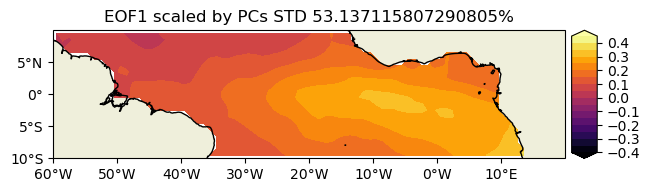

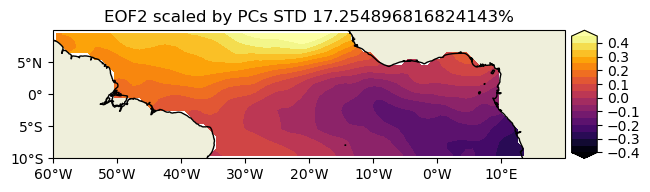

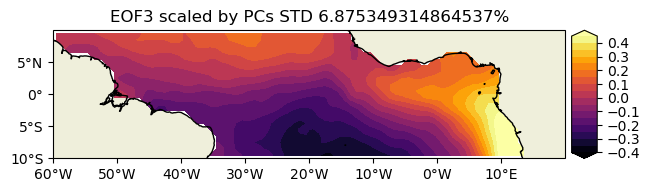

In [17]:
j=0
for i in scaled_EOF['mode'].values:
    mode = scaled_EOF.sel(mode=i)
    ds_map(mode, name=f'EOF{i} scaled by PCs STD {xplained_var[j] * 100 }%')
    j+=1

## PCs

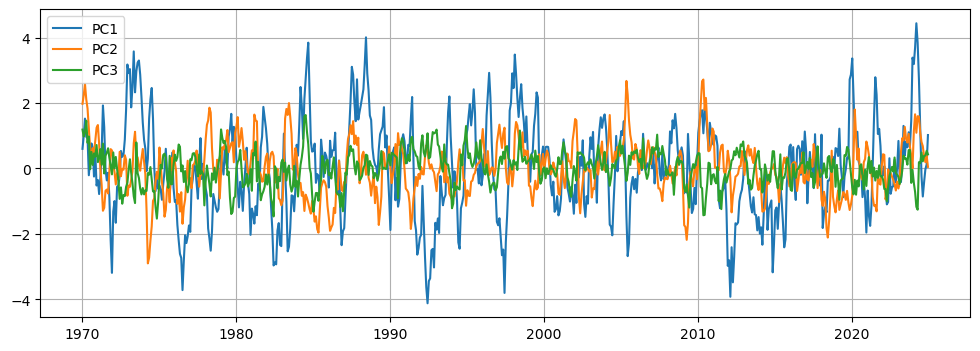

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(PC1.time, PC1, label='PC1')
plt.plot(PC2.time, PC2, label='PC2')
plt.plot(PC3.time, PC3, label='PC3')
plt.legend()
plt.grid()
plt.show()

## CANI EANI patterns

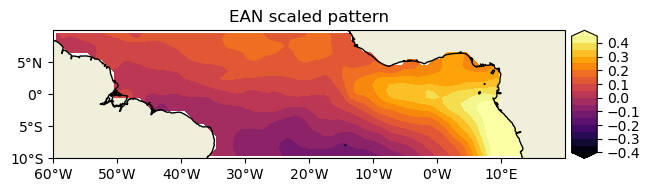

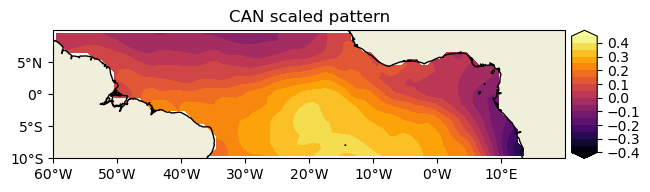

In [19]:
ds_map(EATLs, name=f'EAN scaled pattern')
ds_map(CATLs, name=f'CAN scaled pattern')

## EANI and CANI

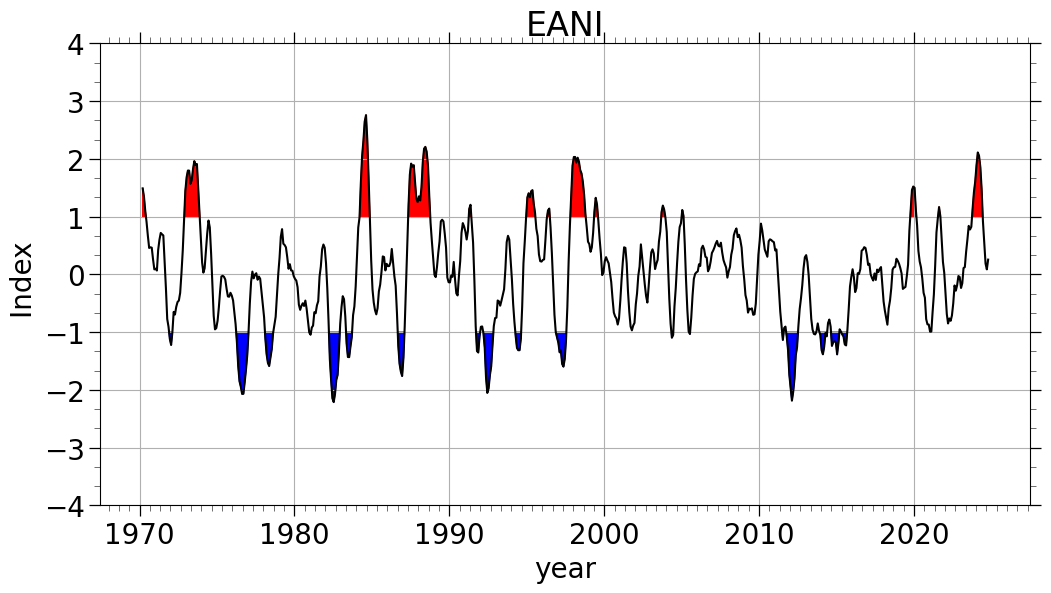

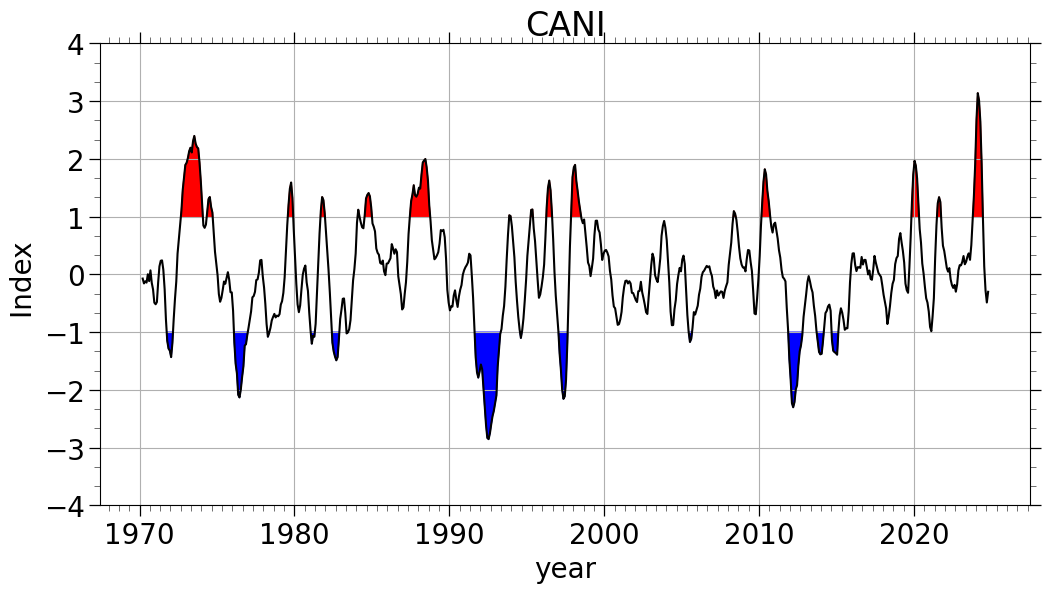

In [37]:
index_plot(EANI_roll, name1='EANI', threshold=1)
index_plot(CANI_roll, name1='CANI', threshold=1)

## Variability

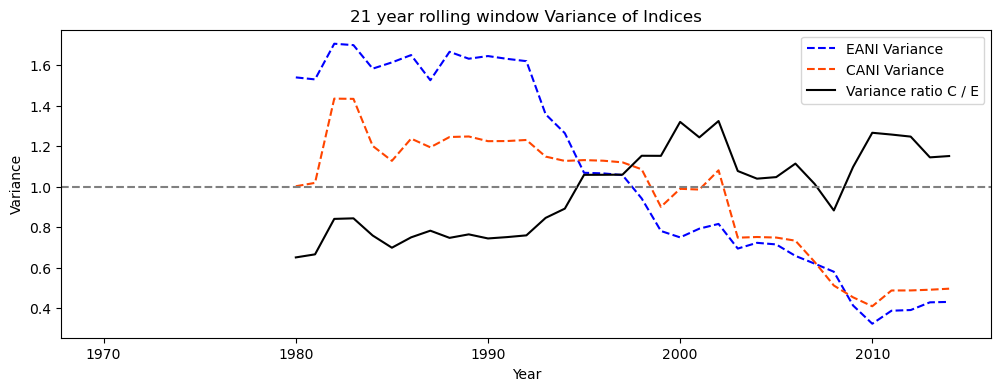

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(EANI_var.year[:], EANI_var[:], label='EANI Variance', color='blue', linestyle='--')
plt.plot(CANI_var.year[:], CANI_var[:], label='CANI Variance', color='orangered', linestyle='--')
plt.plot(CvE_r.year, CvE_r, label='Variance ratio C / E', color='black')
plt.axline((1970, 1), slope=0, color='gray', linestyle='--')
plt.legend()
plt.title('21 year rolling window Variance of Indices')
ax.set_xlabel('Year')
ax.set_ylabel('Variance')
plt.show()

# Export

In [22]:
# time series to export
# EANI_roll
# CANI_roll
# PC1, PC2, PC3
# EANI_var
# CANI_var
# CvE_r

timeseries = xr.Dataset(
    {
        "EANI": (['time'], EANI_roll.data, {
            "description": f"Eastern Atlantic Niño Index. PCs scaled by STD and roll mean of {roll} months"
        }),
        "CANI": (['time'], CANI_roll.data, {
            "description": f"Central Atlantic Niño Index. PCs scaled by STD and roll mean of {roll} months"
        }),
        "PC1": (['time'], PC1.data, {
            "description": "PC1 from EOFa"
        }),
        "PC2": (['time'], PC2.data, {
            "description": "PC2 from EOFa"
        }),
        "PC3": (['time'], PC3.data, {
            "description": "PC3 from EOFa"
        }),
    },
    coords={"time": EANI_roll['time'].values}
)

timeseries.attrs.update({
    "title": "Atlantic Niño Index Timeseries",
    "description": f"Contains EANI, CANI, and PCs from EOFa done on HADISSTv1.1",
    "created": "2025-06-11"
})

# ~/folder does not work here
timeseries.to_netcdf("Results/CANI_EANI_HADISST.nc")